Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})}{p(x|\hat{\mu}, \hat{\alpha})}$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x|\hat{\mu}, \hat{\alpha})/p_{ref}(x)}$$

to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha)\cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Furthermore, instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the toy ttbar model we are using. 

$$f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} = \mu \cdot \frac{p_\text{ttbar}\left(x\right)}{p_{ref}(x)} + \frac{p_\text{wjets}\left(x\right)}{p_{ref}(x)} + \frac{p_\text{single top}\left(x\right)}{p_{ref}(x)}$$

In [1]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt

from coffea.analysis_tools import PackedSelection

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-13 13:01:36.585071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 13:01:37.213301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

In [3]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [4]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [5]:
# Build a pandas dataframe from the arrays for density ratio training and validation
# columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']
dataset_incl = pd.DataFrame(training_features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].ravel())
dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].ravel())

# Some scaling to reduce the spread of pt distributions 
dataset_incl['train_labels_presel'] = train_labels
dataset_incl['type'] = type_vec
dataset_incl['weights'] = weights

In [6]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset_incl['weights_normed'] = weights_normed


Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [7]:
# Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

# Use lepton kinematics and the sum of jet pT observable 
columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi'] # Subset of features which need scaling

In [8]:

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluatePreselNN

preselectionTraining = TrainEvaluatePreselNN(dataset_incl, columns, columns_scaling)

In [11]:
path_to_saved_presel_model = './preselection_saved_NN/'
USE_SAVED_MODEL_PRESEL=False

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.15, random_state=42, path_to_save=path_to_saved_presel_model)

else:
    preselectionTraining.get_trained_model(path_to_saved_presel_model)

Epoch 1/20
2930/2930 [==============================] - 12s 4ms/step - loss: 6.7026e-07 - accuracy: 0.6935 - val_loss: 5.5129e-07 - val_accuracy: 0.7212
Epoch 2/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.4499e-07 - accuracy: 0.7217 - val_loss: 5.4299e-07 - val_accuracy: 0.7206
Epoch 3/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.4260e-07 - accuracy: 0.7213 - val_loss: 5.4257e-07 - val_accuracy: 0.7206
Epoch 4/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.4236e-07 - accuracy: 0.7212 - val_loss: 5.4249e-07 - val_accuracy: 0.7208
Epoch 5/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.4226e-07 - accuracy: 0.7213 - val_loss: 5.4237e-07 - val_accuracy: 0.7207
Epoch 6/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.4218e-07 - accuracy: 0.7213 - val_loss: 5.4233e-07 - val_accuracy: 0.7211
Epoch 7/20
2930/2930 [==============================] - 11s 4ms/step - loss: 5.421

In [12]:
# Get predictions (softmax outputs)
pred_NN = preselectionTraining.predict(dataset_incl)

110289/110289 [==============================] - 67s 604us/step


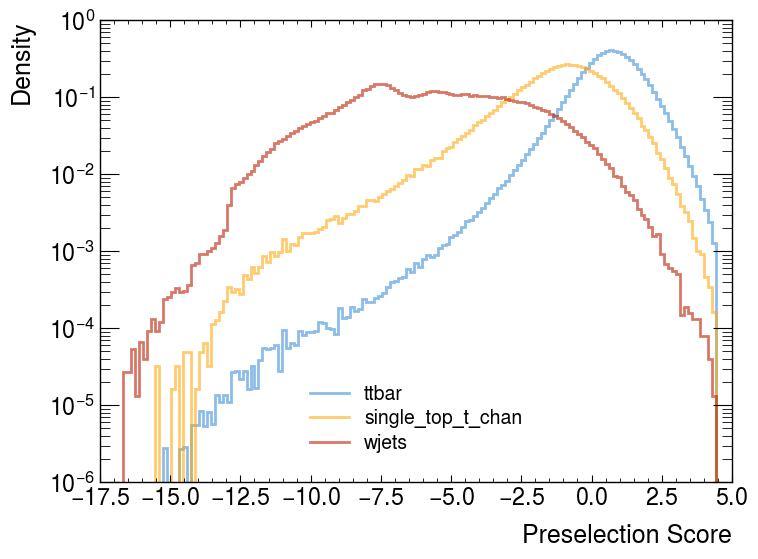

In [13]:
# the preselection score as defined above - log(P_S/P_B)
presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(pred_NN[:, labels_dict["single_top_t_chan"]] + pred_NN[:, labels_dict["wjets"]]))

min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}
for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a Control Region for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the Signal Region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions. 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

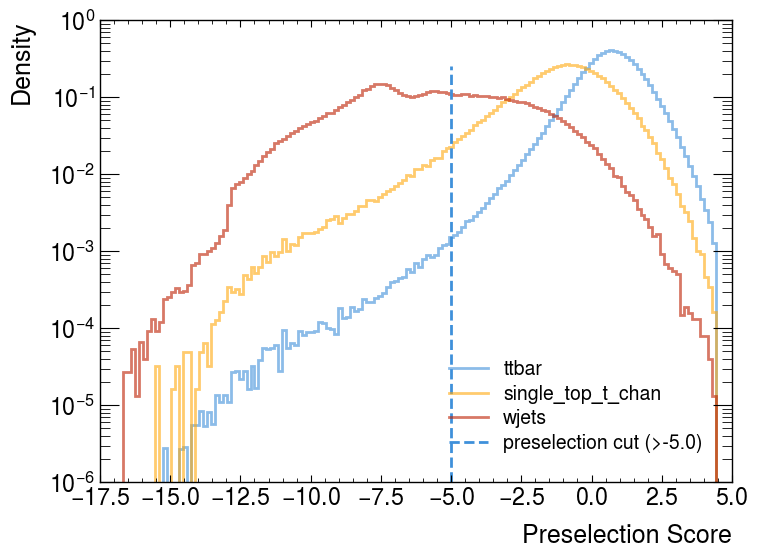

In [14]:
preselection_cut_lower = -5.0 # Play around with this selection - 
                              # decrease if estimators are unbiased but need more sensitivity 
                              # and increase if the model is biased to reduce complexity

# Uncomment the line below if an upper cut is also needed
# preselection_cut_upper = -5.0

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut_lower, ymax=0.9, linestyle='--', label=f'preselection cut (>{preselection_cut_lower})')

# Uncomment the line below if an upper cut is also needed
# plt.axvline(preselection_cut_upper, ymax=0.9, linestyle='--', label=f'preselection cut (<{preselection_cut_upper})')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
# Make the preselections

dataset_incl['presel_score'] = presel_score

dataset = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower)].copy()

# Uncomment the line below if an upper cut is also needed
# dataset = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower) & (dataset_incl.presel_score<=preselection_cut_upper)].copy()

# Additional selections - change as needed to get unbiased estimators / remove unwanted or badly modelled phase space regions
dataset = dataset[(dataset.lepton_pt<=200.0)].copy()

In [16]:
# Normalizing the training weights post preselection - only discriminating shapes, not norms

weights_normed = dataset['weights'].ravel().copy()
weights = dataset['weights'].ravel().copy()

for key in labels_dict:

    weights_normed[dataset['train_labels_presel']==labels_dict[key]] /= weights[dataset['train_labels_presel']==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed

In [17]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{ttbar}(x) = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_\text{wjets}\left(x\right)}{p_\text{ttbar}(x)} + \frac{p_\text{single top}\left(x\right)}{p_\text{ttbar}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

Starting with $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$:

In [18]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [19]:
NN_training_channels_dict = {}


In [20]:

rnd_seed_traintestsplit = 42
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['wjets'] = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                                                       dataset_ch_wjets_ref['weights_normed'],
                                                       dataset_ch_wjets_ref['train_labels'],
                                                       columns, 
                                                       columns_scaling, rnd_seed_traintestsplit, 
                                                       channel_names, output_dir, output_name, 
                                                        path_to_figures=path_to_figures,
                                                        path_to_ratios=path_to_ratios, 
                                                        path_to_models=path_to_models)



Neural Network architecture
===

Here we will start with a multi-layer perceptron (simple feed-forward Neural Network with fully-connected layers). This can be supplemented with more complex architectures like transformers. 

After detailed tuning during the off-shell Higgs boson analysis effort, we found that a network with very wide layers ($\geq 1000$) and a depth of less than 10 works best - alongside batch size of a few hundreds and a gradually declining learning rate that starts with a value just large enough to not blow up.

Sum of weights of class 0: 0.7999990850408755
Sum of weights of class 1: 0.7999923120851443
Using swish activation function
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000)              5000      
                                                                 
 dense_7 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_8 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1007001 (3.84 MB)
Trainable params: 1007001 (3.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/70
3893/3893 - 11s - loss: 1.8577e-07 - binary_accuracy: 0.9019 - val_loss: 1.8279e-07 - val_binary_accuracy: 0.9035 - lr: 0.1000 - 

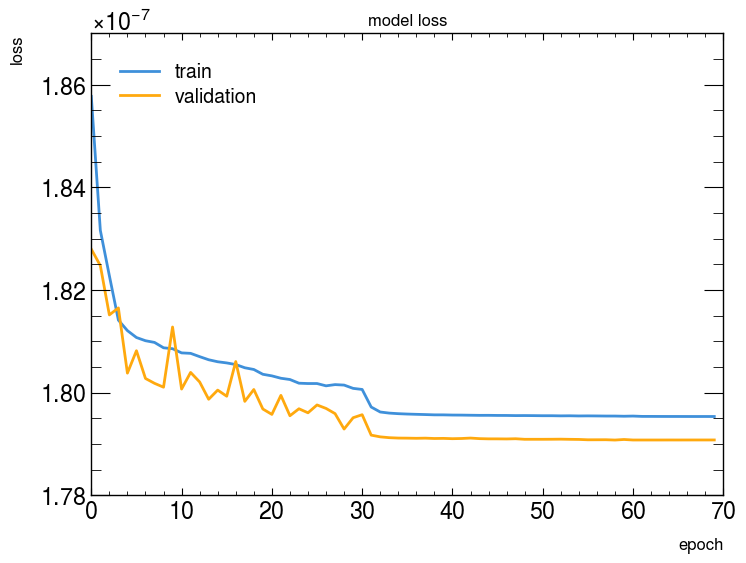

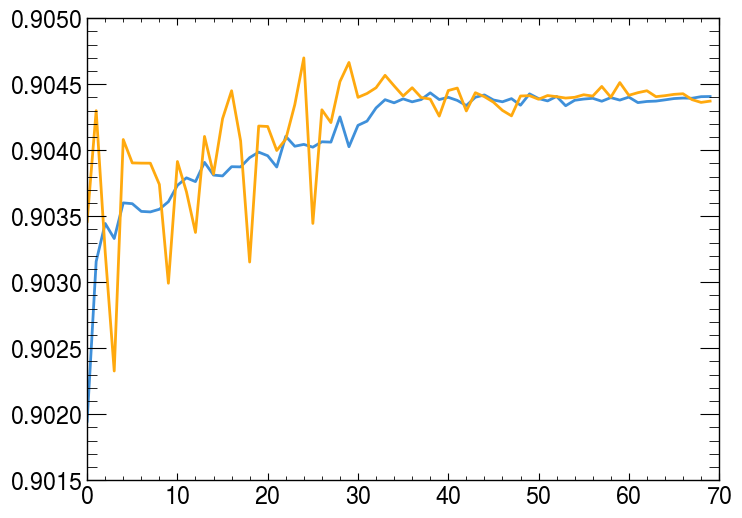

1367/1367 - 1s - 797ms/epoch - 583us/step
15936/15936 - 9s - 9s/epoch - 589us/step
5465/5465 - 3s - 3s/epoch - 546us/step
63745/63745 - 35s - 35s/epoch - 549us/step
ttbar training data prediction (max) = 0.9879126
ttbar training data prediction (min) = 0.0030792027
wjets training data prediction (max) = 0.98826116
wjets training data prediction (min) = 0.0032062104
ttbar training data prediction (max) = 0.98793286
ttbar training data prediction (min) = 0.003116669
wjets training data prediction (max) = 0.98823047
wjets training data prediction (min) = 0.003118582


<Figure size 800x600 with 0 Axes>

In [21]:
# Train the density ratio NN
NN_training_channels_dict['wjets'].train(hidden_layers=2, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=512, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


Check for overtraining by comparing the NN output distributions between training and holdout datasets. The holdout dataset is the subset of events not used during training.

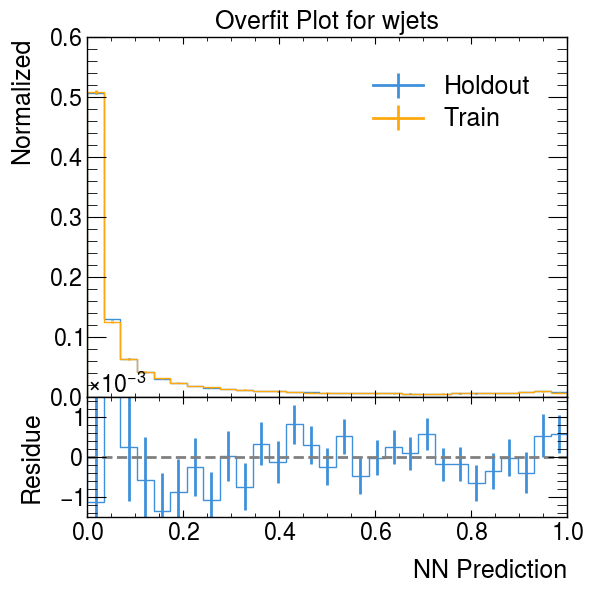

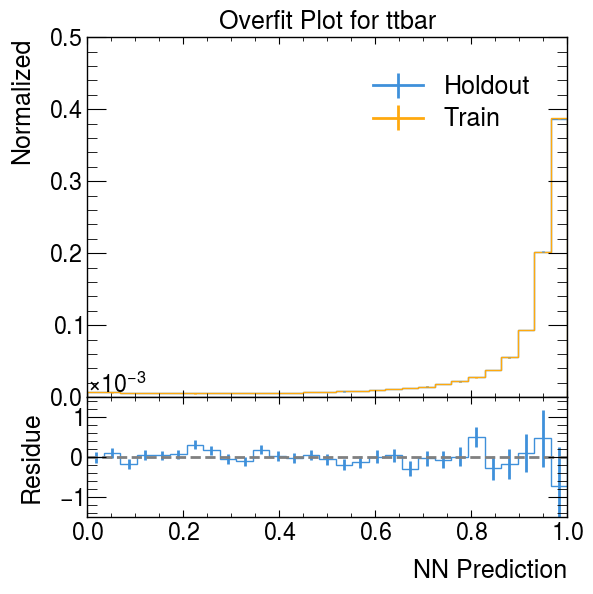

<Figure size 800x600 with 0 Axes>

In [22]:
NN_training_channels_dict['wjets'].make_overfit_plots()

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{ttbar}(x)}{p_\text{ttbar}(x)+p_\text{wjets}(x)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{wjets}(x)}{p_\text{ttbar}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_c(x)}{p_c(x)+p_{ref}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


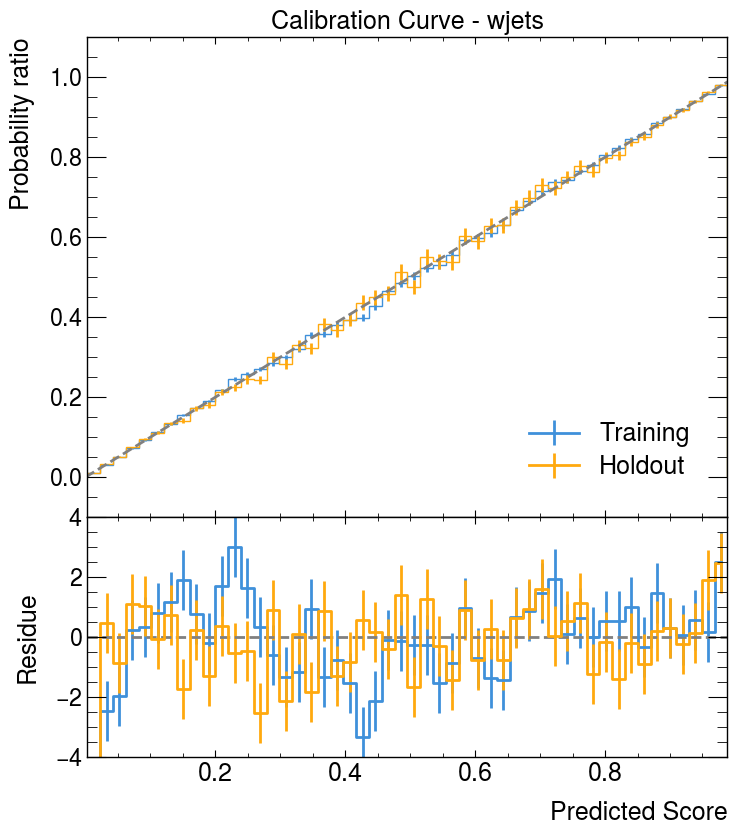

observable not recognized


<Figure size 800x600 with 0 Axes>

In [23]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

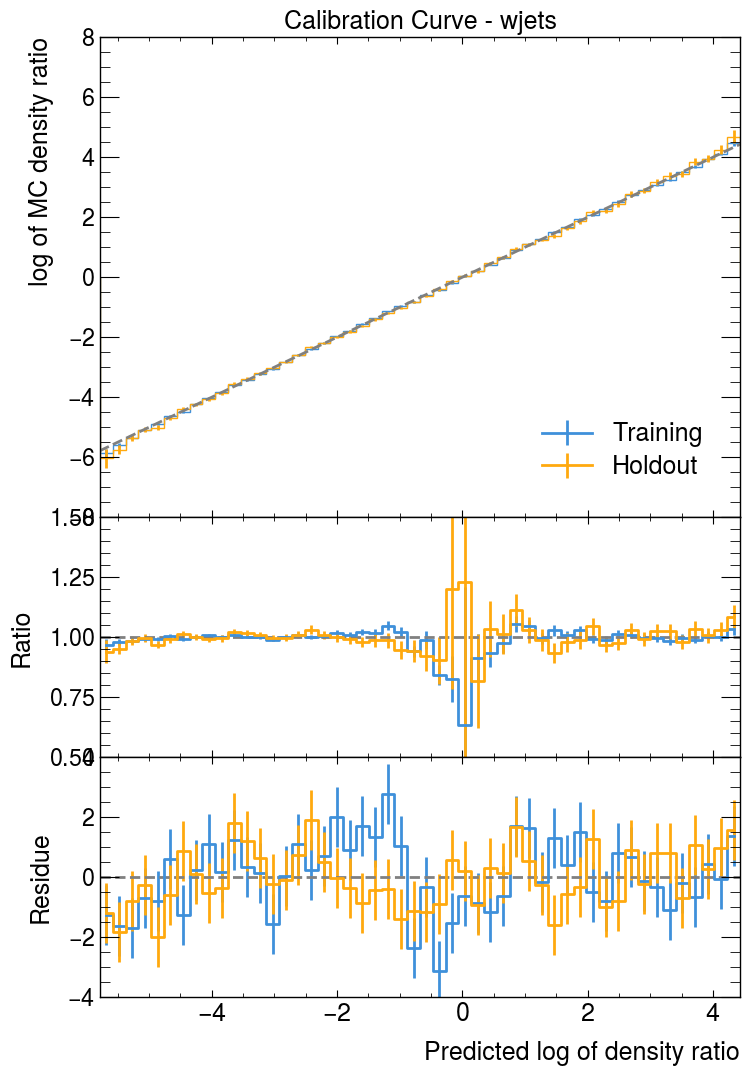

<Figure size 800x600 with 0 Axes>

In [24]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

- **Density ratio reweighting closure tests**
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_c(x)}{p_{ref}(x)} \times p_{ref}(x) \sim p_c(x)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

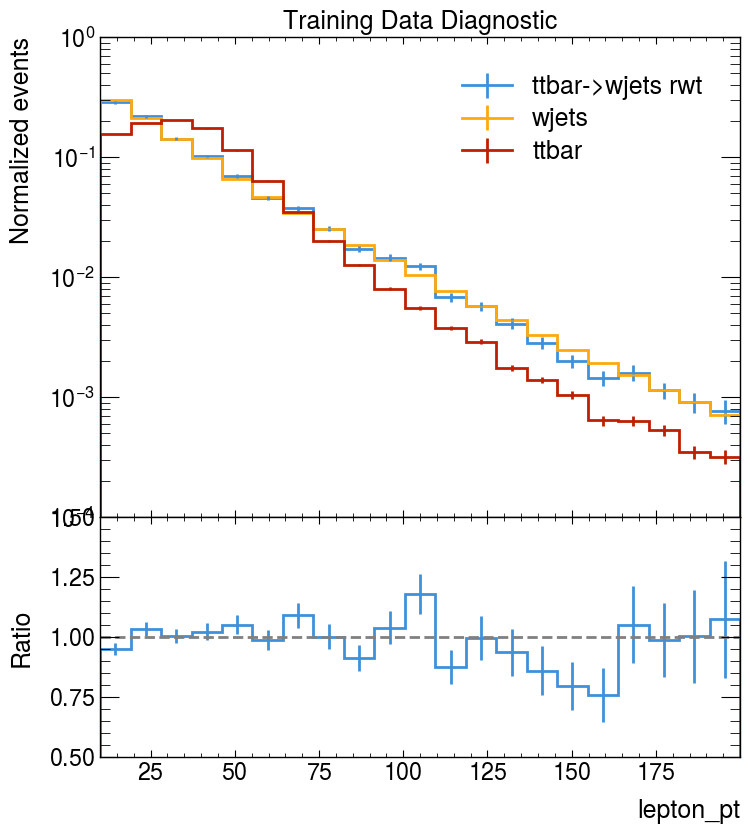

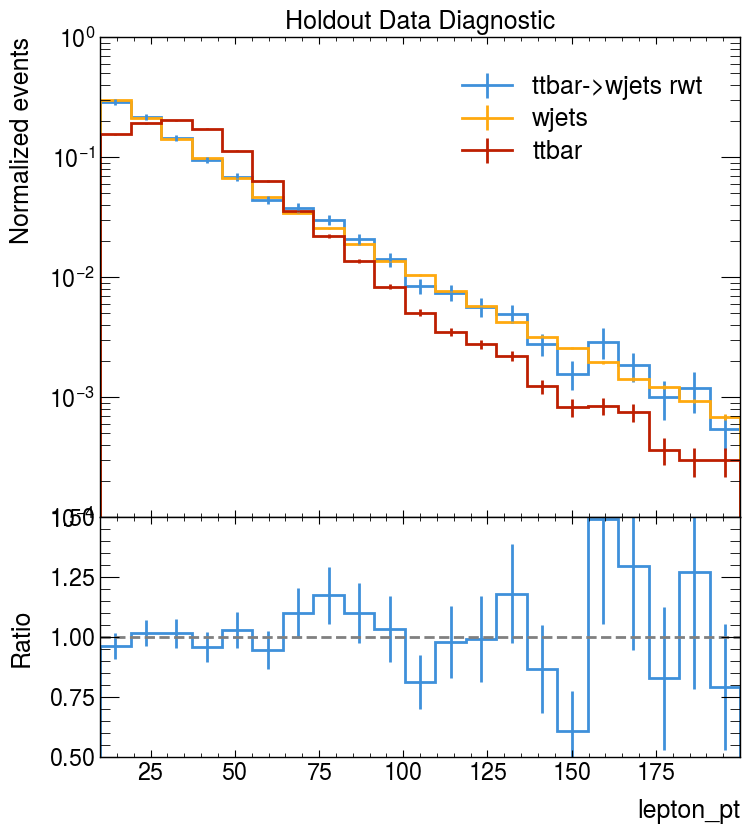

<Figure size 800x600 with 0 Axes>

In [25]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


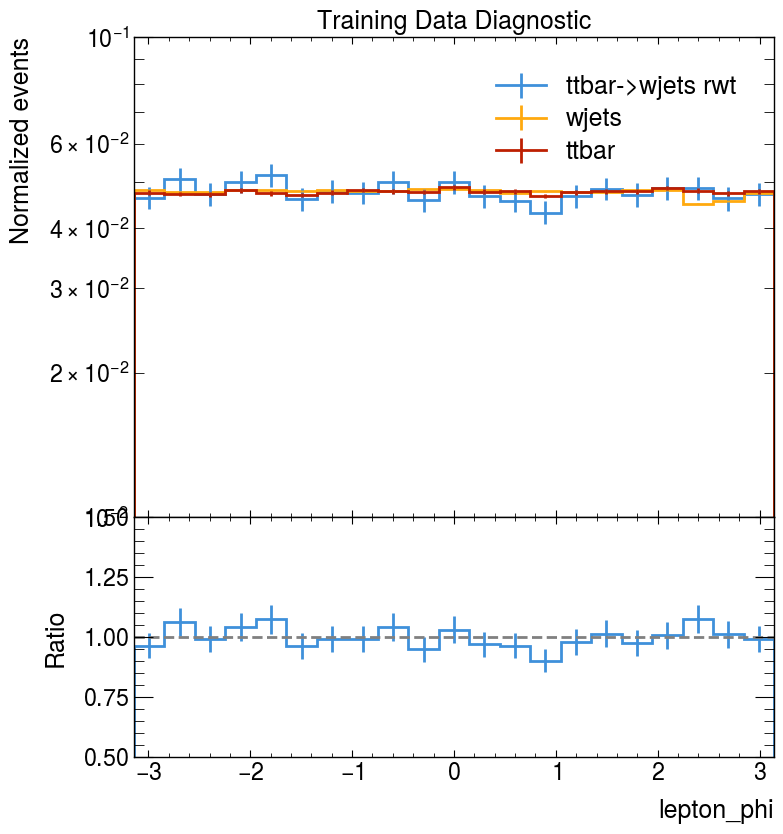

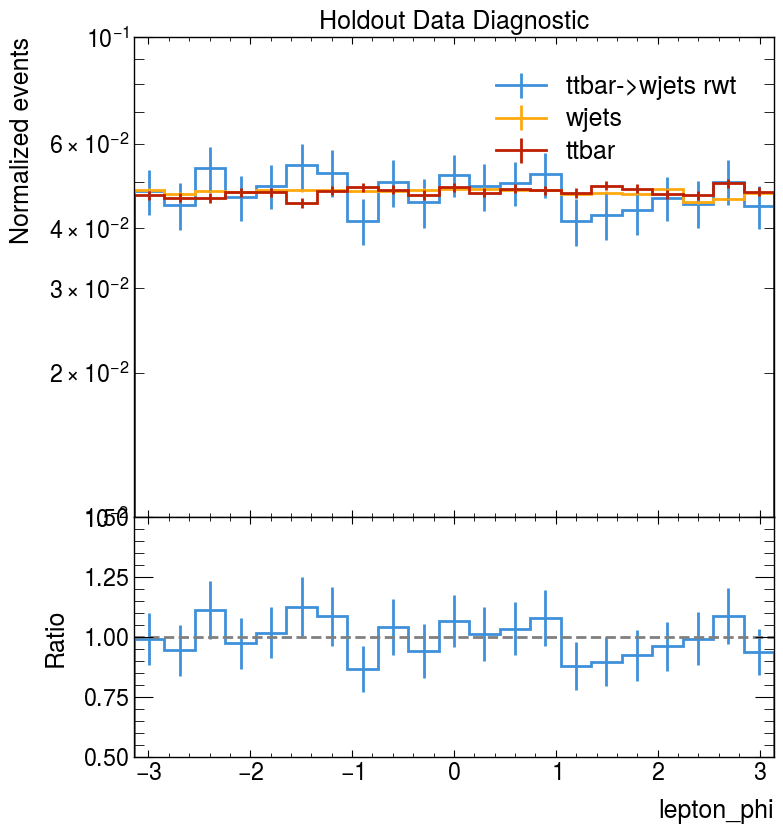

<Figure size 800x600 with 0 Axes>

In [26]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


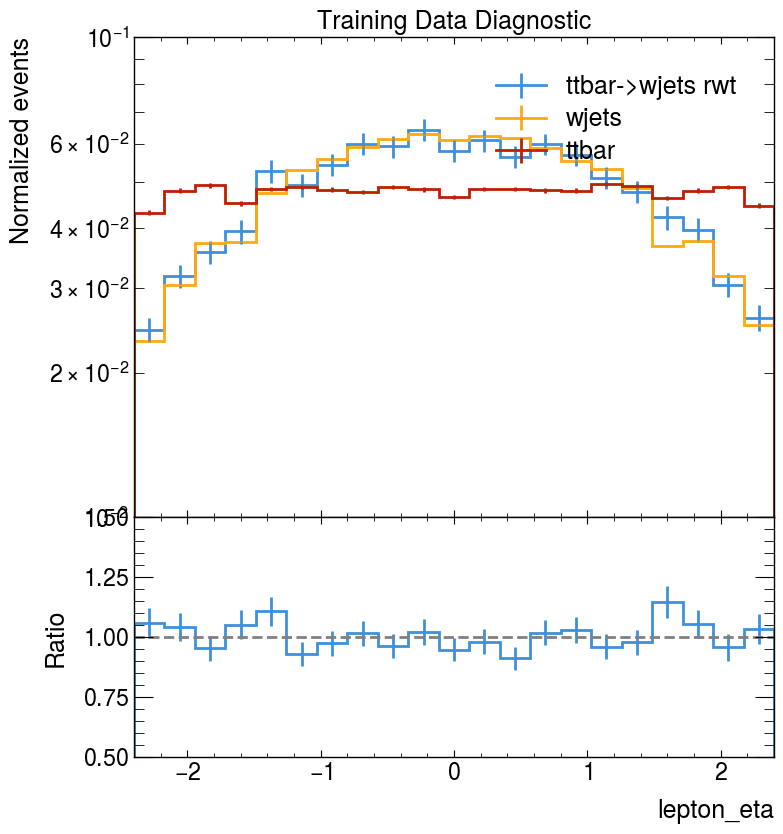

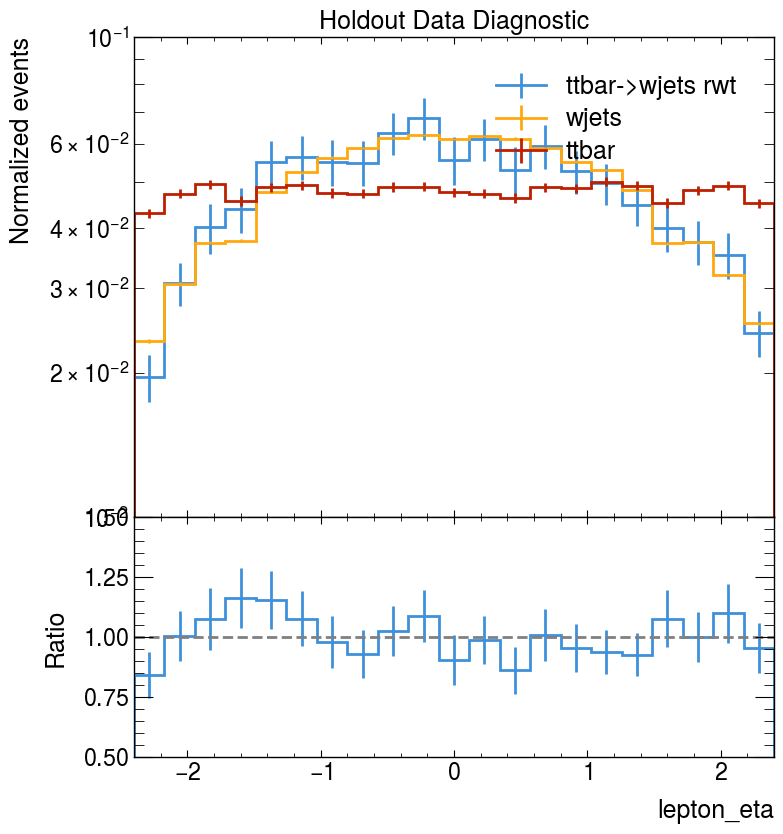

<Figure size 800x600 with 0 Axes>

In [27]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


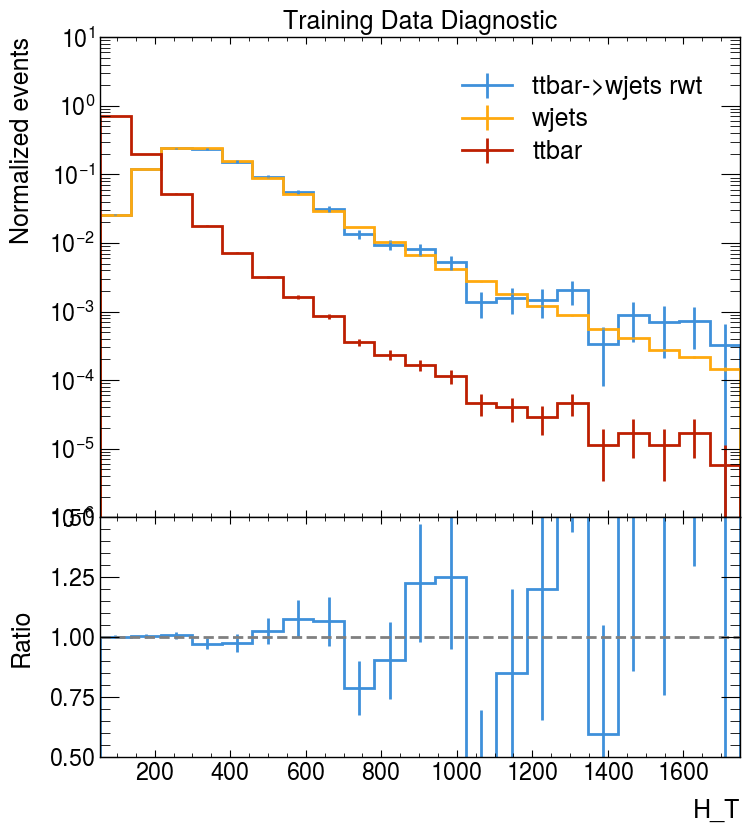

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:290: RuntimeWarning: invalid value encountered in divide
  axs[1, j].set_ylim(0.5, 1.5)


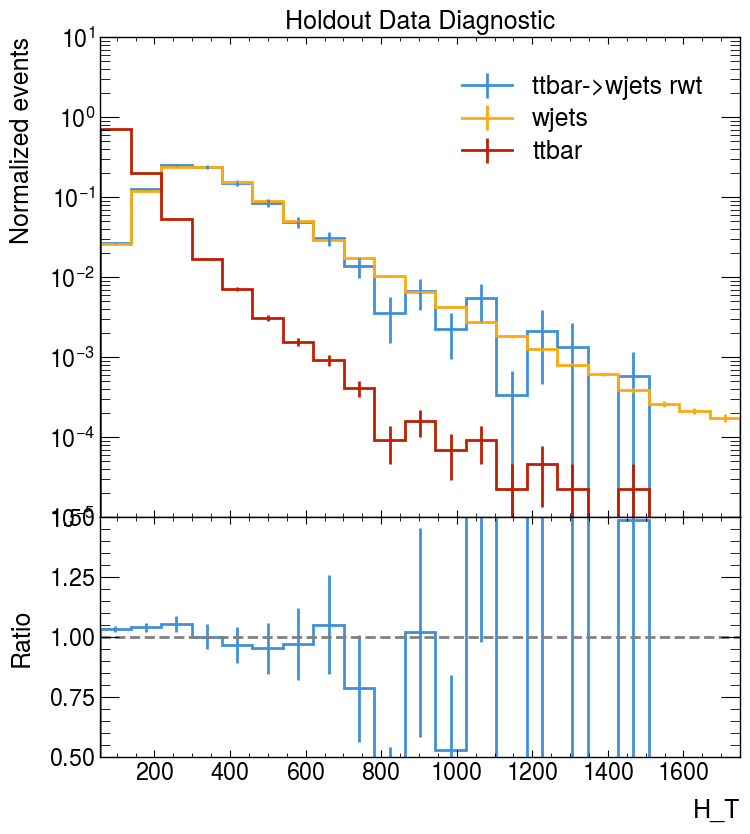

<Figure size 800x600 with 0 Axes>

In [60]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


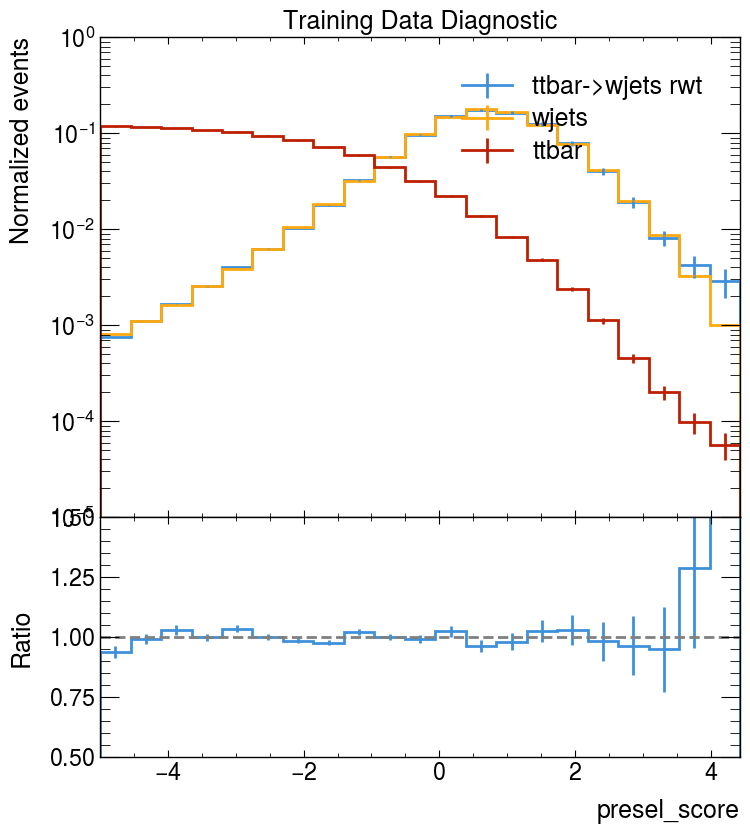

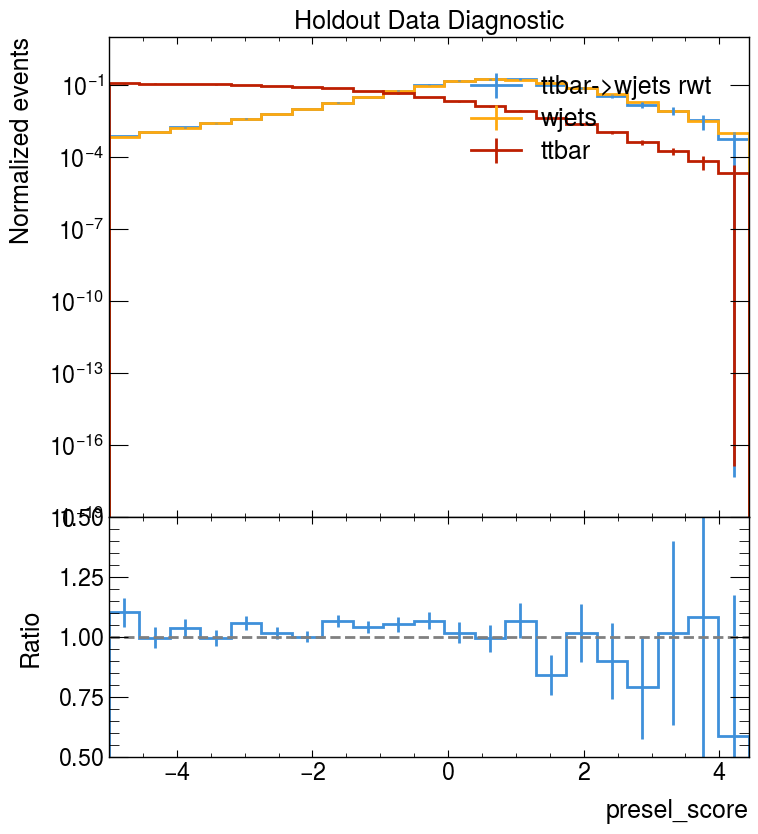

<Figure size 800x600 with 0 Axes>

In [29]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [30]:
NN_training_channels_dict['wjets'].evaluate_and_save_ratios(dataset)


99564/99564 - 56s - 56s/epoch - 558us/step


Now for the training and validation of the other density ratio:

$$\frac{p_\text{single top}(x)}{p_\text{ttbar}(x)}$$

In [31]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                              dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [32]:

rnd_seed_traintestsplit = 4242
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['singletop'] = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



Sum of weights of class 0: 0.7999999999999998
Sum of weights of class 1: 0.7999951324781395
Using swish activation function
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1000)              5000      
                                                                 
 dense_10 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_11 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 1007001 (3.84 MB)
Trainable params: 1007001 (3.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/70
4173/4173 - 13s - loss: 3.5983e-07 - binary_accuracy: 0.7490 - val_loss: 3.5704e-07 - val_binary_accuracy: 0.7498 - lr: 0.1000 - 

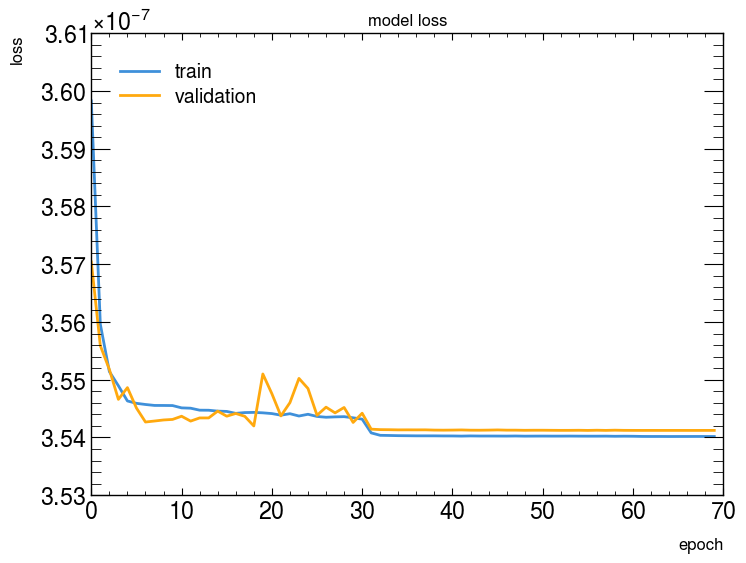

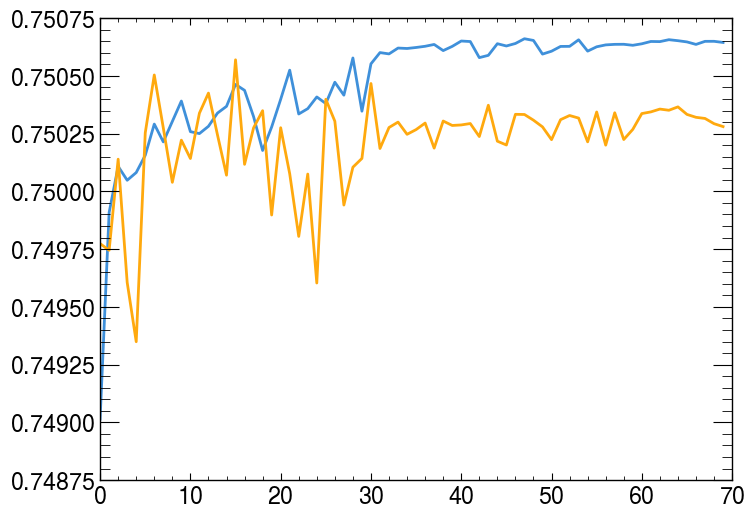

2611/2611 - 1s - 1s/epoch - 569us/step
15936/15936 - 9s - 9s/epoch - 582us/step
10442/10442 - 6s - 6s/epoch - 542us/step
63745/63745 - 35s - 35s/epoch - 545us/step
ttbar training data prediction (max) = 0.8550679
ttbar training data prediction (min) = 0.023448732
single_top_t_chan training data prediction (max) = 0.8560418
single_top_t_chan training data prediction (min) = 0.033958886
ttbar training data prediction (max) = 0.85473746
ttbar training data prediction (min) = 0.029867912
single_top_t_chan training data prediction (max) = 0.8559117
single_top_t_chan training data prediction (min) = 0.03536169


<Figure size 800x600 with 0 Axes>

In [33]:
# Train the density ratio NN
NN_training_channels_dict['singletop'].train(hidden_layers=2, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=512, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


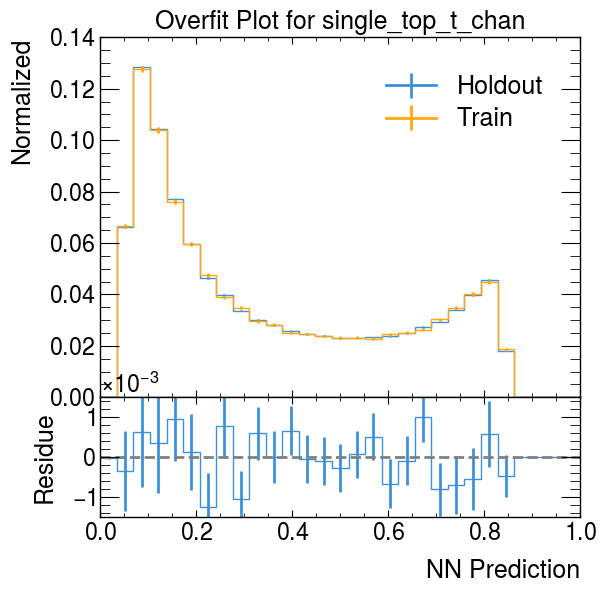

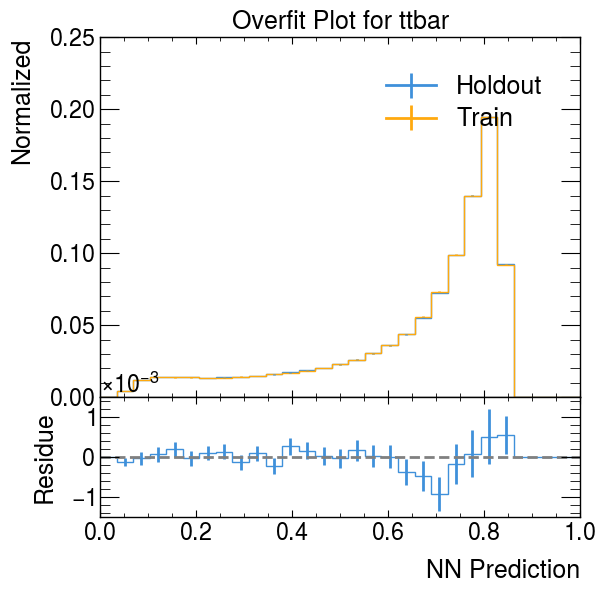

<Figure size 800x600 with 0 Axes>

In [34]:
NN_training_channels_dict['singletop'].make_overfit_plots()

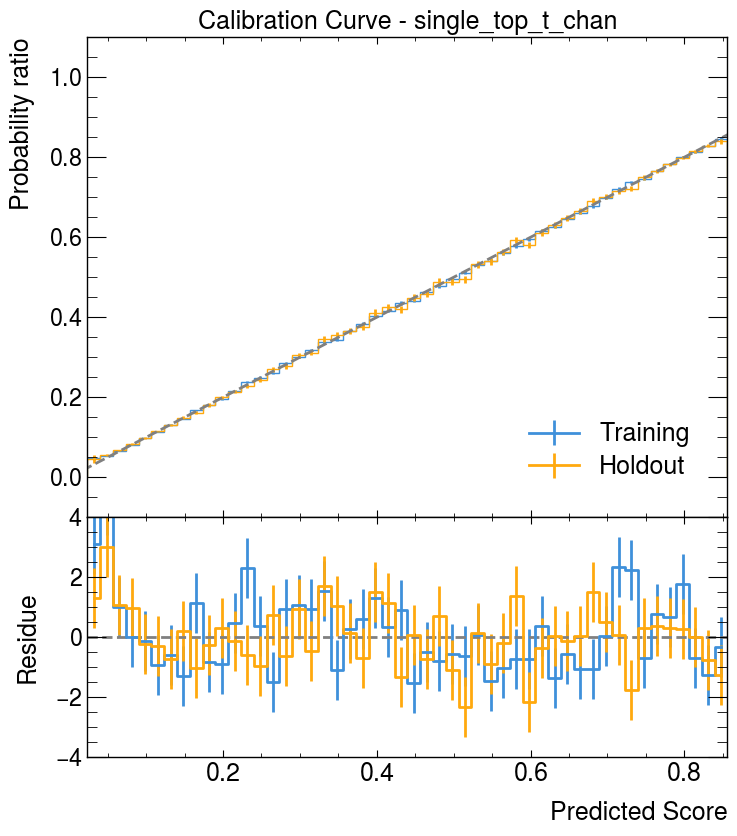

observable not recognized


<Figure size 800x600 with 0 Axes>

In [35]:
num_bins_cal = 50
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='score')

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:156: RuntimeWarning: invalid value encountered in divide
  h_log = np.log(hist_num/hist_den)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:156: RuntimeWarning: divide by zero encountered in log
  h_log = np.log(hist_num/hist_den)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:157: RuntimeWarning: invalid value encountered in divide
  h_log_err = np.sqrt((hist_num_err/hist_num**2)+(hist_den_err/hist_den**2))
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: invalid value encountered in divide
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: divide by zero encountered in log
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)


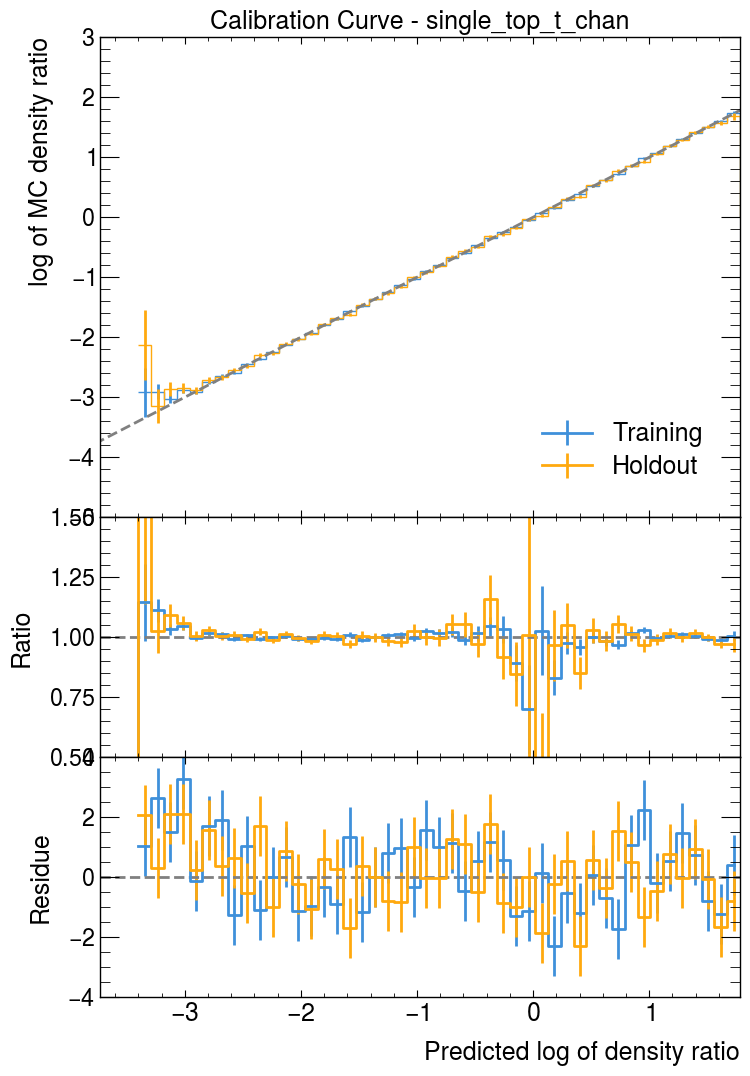

<Figure size 800x600 with 0 Axes>

In [36]:
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='llr')


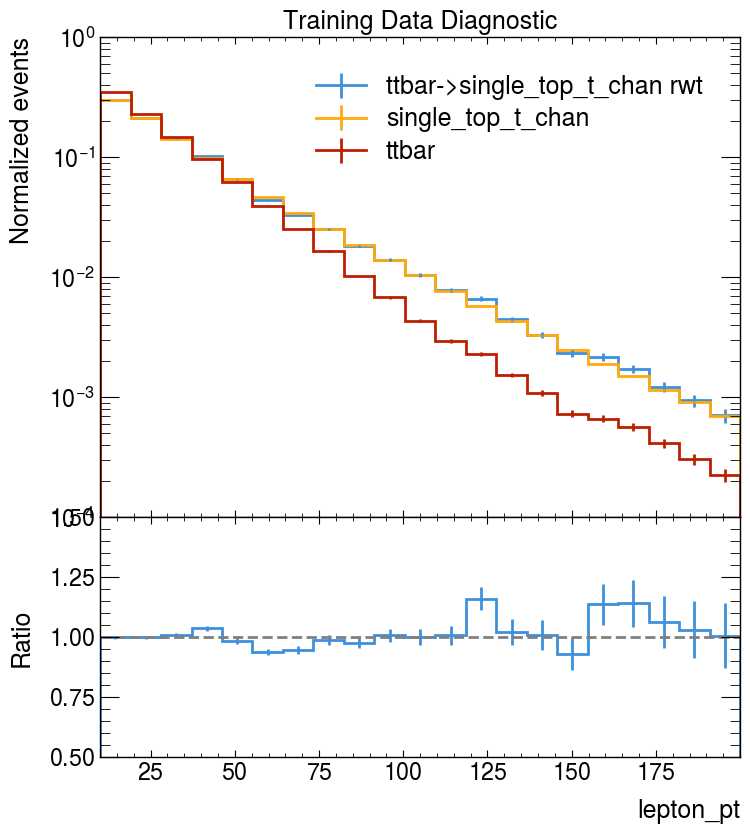

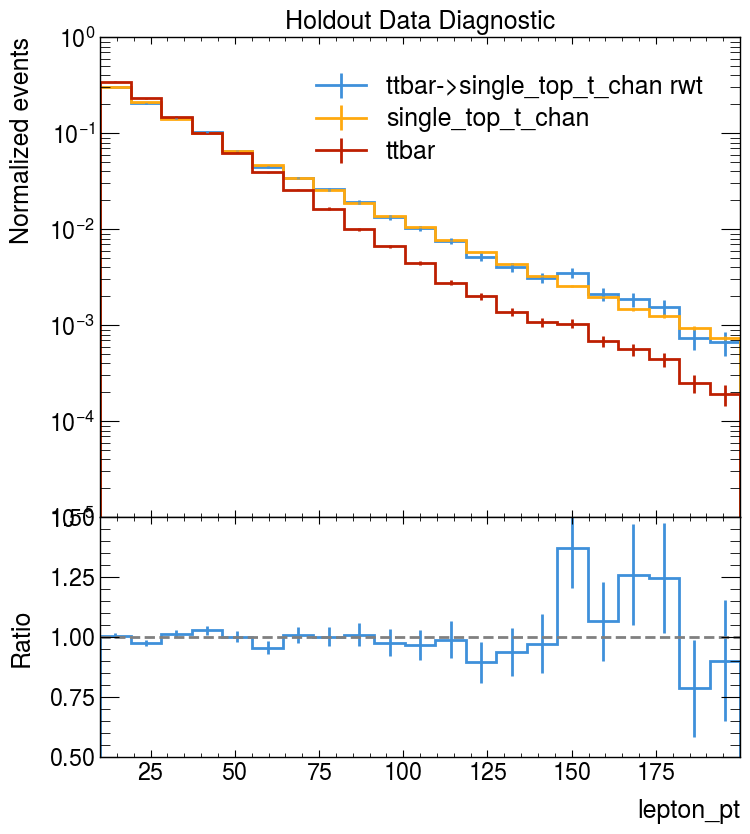

<Figure size 800x600 with 0 Axes>

In [37]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


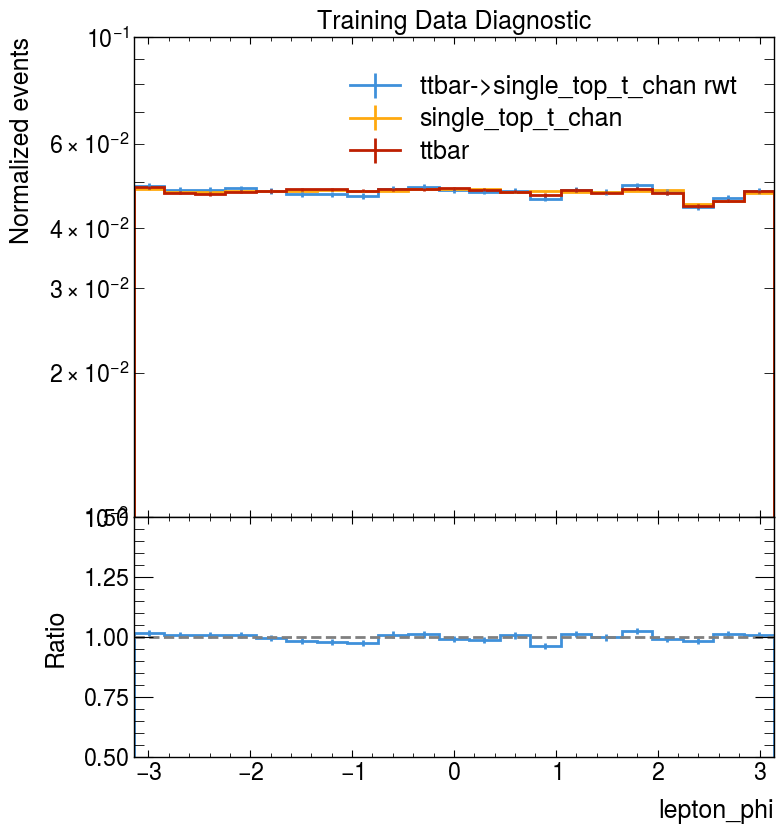

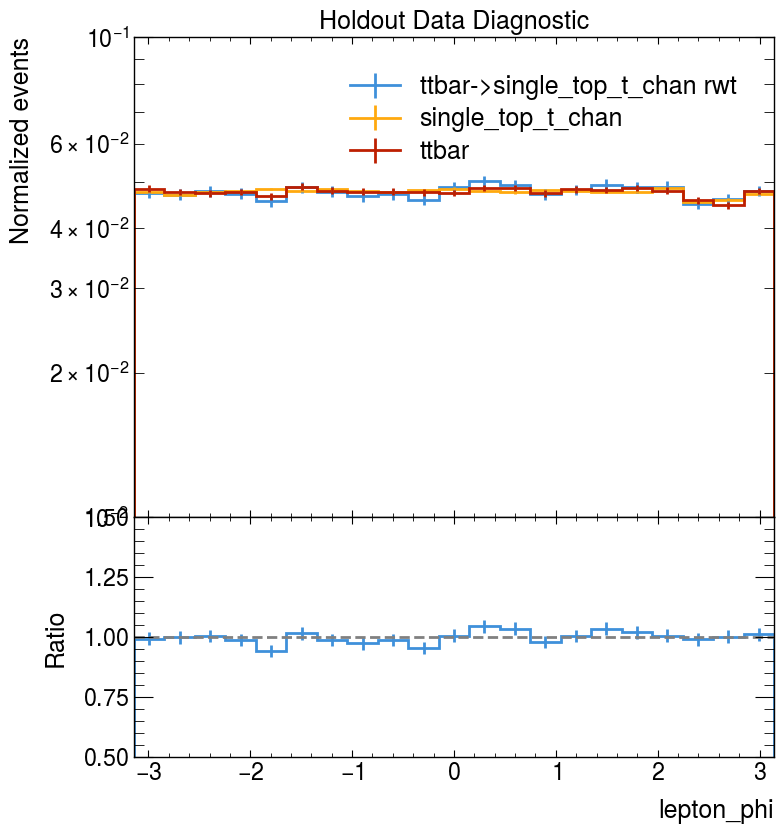

<Figure size 800x600 with 0 Axes>

In [38]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


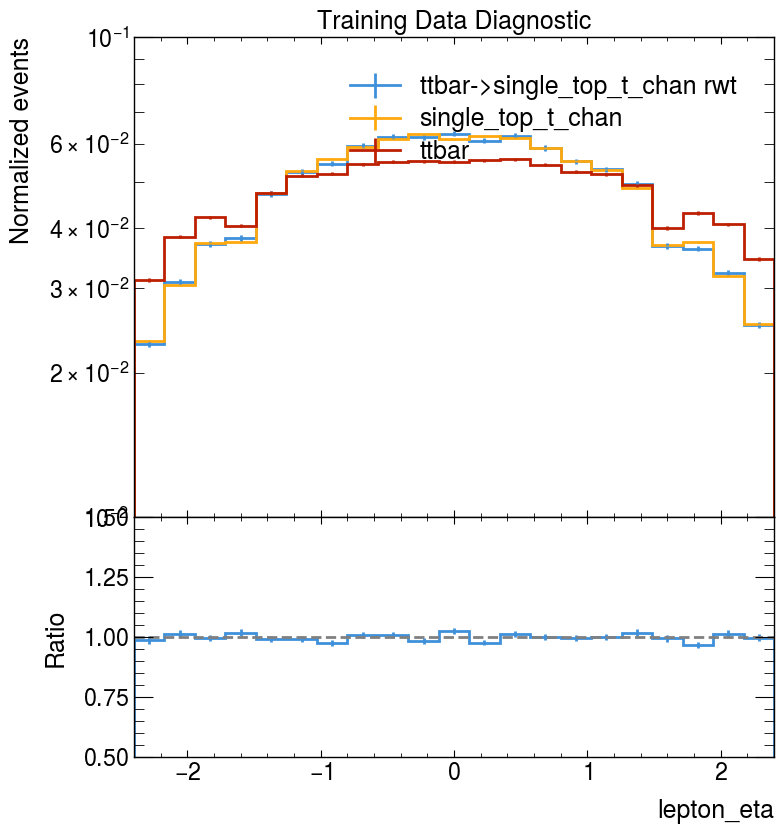

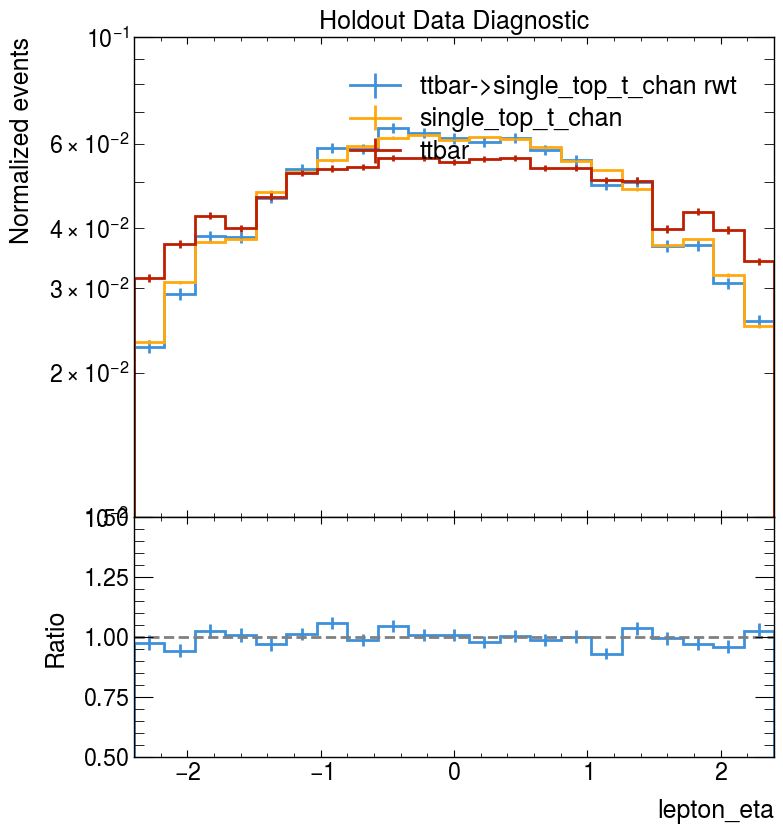

<Figure size 800x600 with 0 Axes>

In [39]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


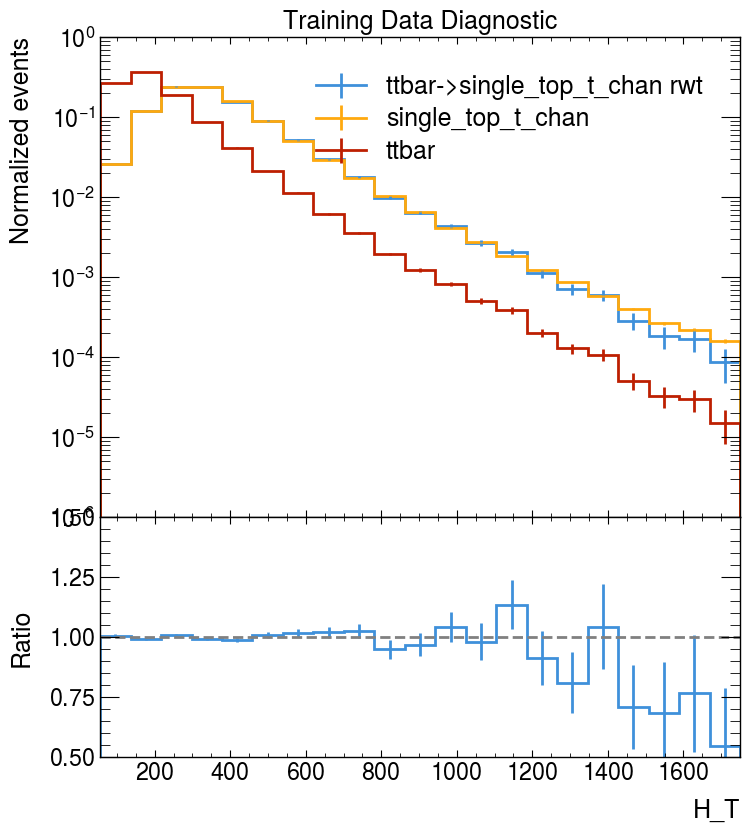

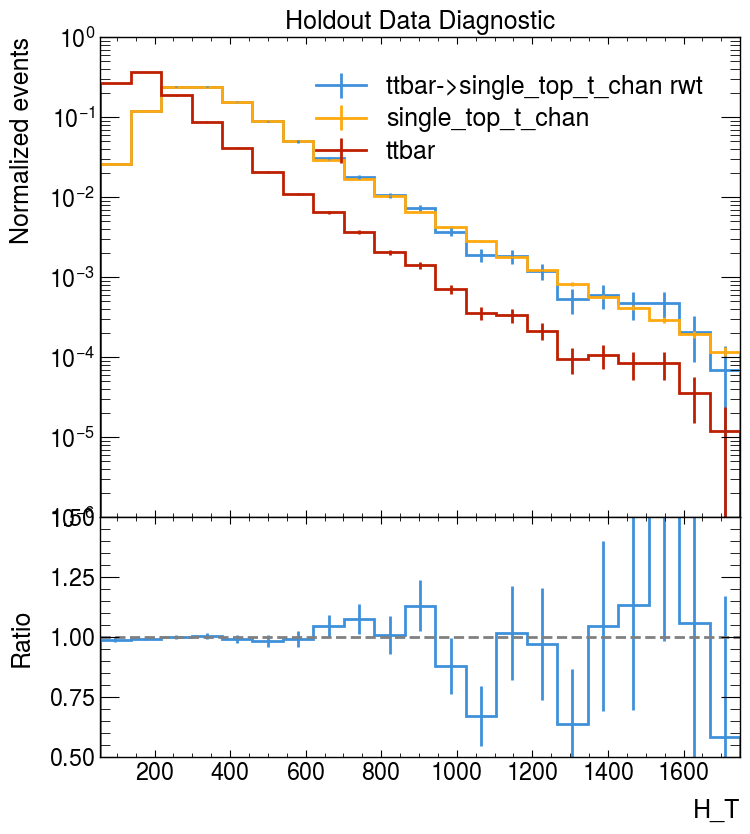

<Figure size 800x600 with 0 Axes>

In [40]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


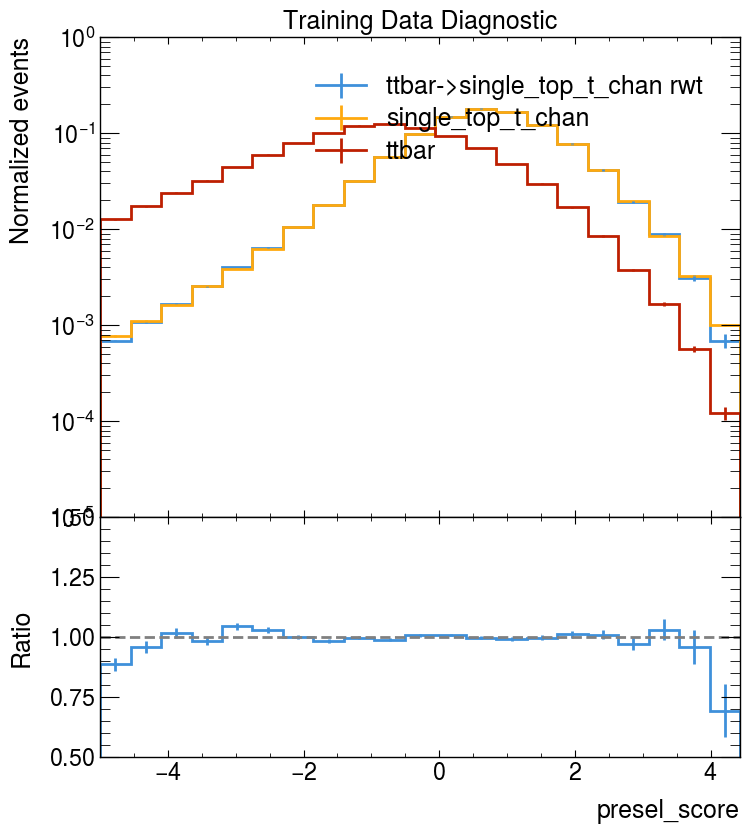

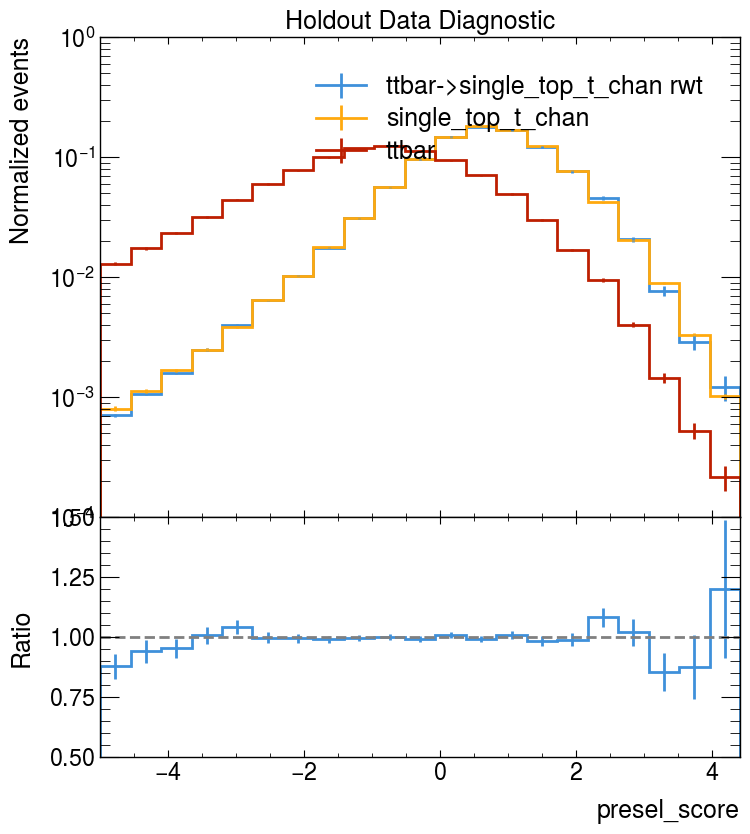

<Figure size 800x600 with 0 Axes>

In [41]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [42]:
NN_training_channels_dict['singletop'].evaluate_and_save_ratios(dataset)


99564/99564 - 54s - 54s/epoch - 546us/step


Training an Ensemble of NNs
===

In a realistic analysis, a large ensemble of NNs are trained to estimate density ratios, for *each* of the channels. **This reduces not only the variance but has also been found to reduce biases in the final fits.**

In the off-shell Higgs boson analysis, we used k-fold cross-validation, with k=10, to train an ensemble $N_{ens}\sim 250$ of NNs per density ratio $p_c(x)/p_{ref}(x)$. The density ratios used in the final fit are always evaluated on the holdout dataset and by using each of the folds as holdout once, the entire model for $p_c(x)/p_{ref}(x)$ consists of $N_{ens}\times k \sim 2500$ NNs. Each NN in the ensemble is trained by resampling data without replacement from the k-1 folds used for training.

Systematic Uncertainty Modelling
===

So far we have left out the nuisance parameter piece of the parameterized density ratio decomposition shown before:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that the effect of various sources of uncertainty in the model can be factorized. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

This is done for each systematic uncertainty and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

**The workflow presented in this tutorial lacks nuisance paramter modelling. Will be adding soon!**

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

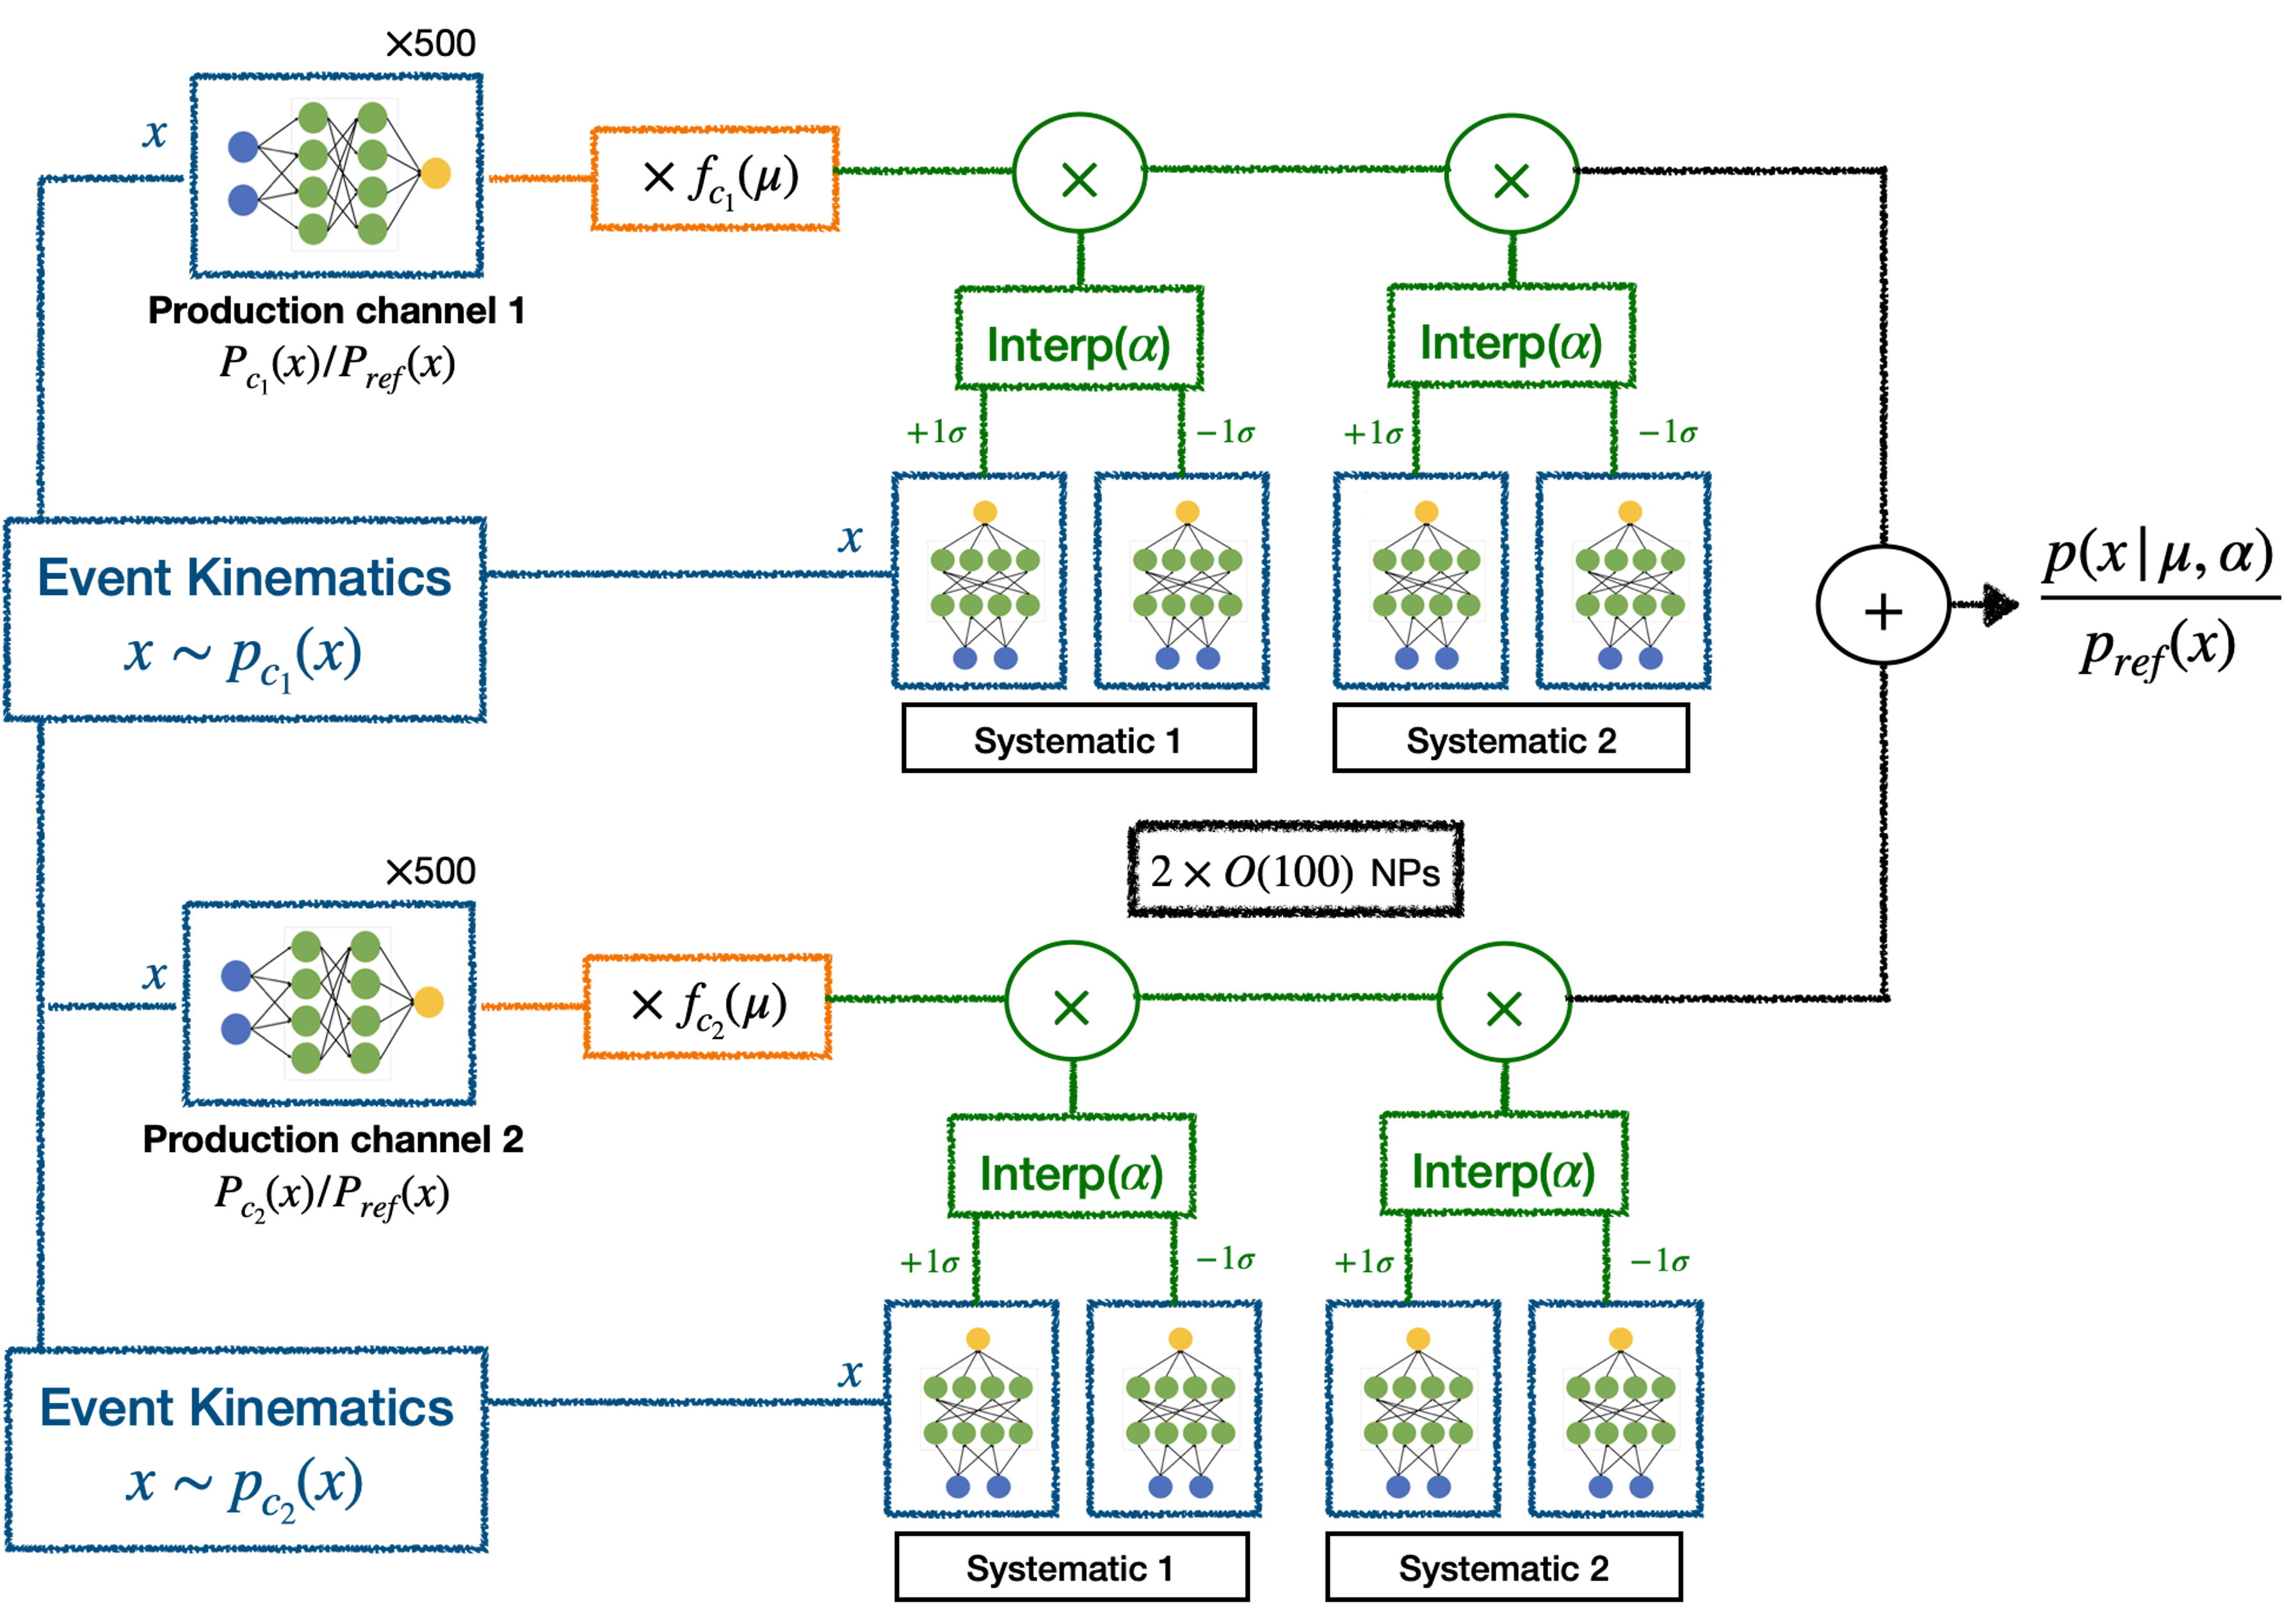

In [44]:
# backup code for updating class methods - only for debugging phase
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training_channels_dict['wjets'].make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_overfit_plots = types.MethodType(TrainEvaluate_NN.make_overfit_plots, NN_training_channels_dict['wjets'])
